<a href="https://colab.research.google.com/github/Alamsyah-WM/Predict-DNA-binding-protein-with-ML-and-DL/blob/main/BioInformatik_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Library

In [62]:
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plotting
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.preprocessing import StandardScaler  # For scaling features
from collections import Counter # For counting features
from sklearn.svm import SVC # For Classification model SVM
from sklearn.neural_network import MLPClassifier # For MLP Classifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # For evaulate model performance

##Load Dataset

In [26]:
pdb = pd.read_csv('/content/PDB1063-186.csv')
uniswiss = pd.read_csv('/content/UniSwiss.csv')

print("Raw PDB Dataset:")
print(pdb.head())

print("\nRaw UniSwiss Dataset:")
print(uniswiss.head())

print("\nPDB Info:")
print(pdb.info())
print("Shape:", pdb.shape)

print("\nUniSwiss Info:")
print(uniswiss.info())
print("Shape:", uniswiss.shape)

Raw PDB Dataset:
  identifier                                           sequence  label    set
0      1AKHB  TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...      1  train
1      1B6WA  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...      1  train
2      1C1KA  MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...      1  train
3      1C6VX  QQSKNSKFKNFRVYYREGRDQLWKGPGELLWKGEGAVLLKVGTDIK...      1  train
4      1C6VD  IHGQVNSDLGTWQMDCTHLEGKIVIVAVHVASGFIEAEVIPQETGR...      1  train

Raw UniSwiss Dataset:
   identifier                                           sequence  label    set
0      P08956  MMNKSNFEFLKGVNDFTYAIACAAENNYPDDPNTTLIKMRMFGEAT...      1  train
1      P27235  MPPQRSRRRKRASATQLYQTCKASGTCPPDVIPKVEGTTLADKILQ...      1  train
2      P0AD01  MINVLIIDDDAMVAELNRRYVAQIPGFQCCGTASTLEKAKEIIFNS...      1  train
3  A0A024B7I0  MAYMCADSGNLMAIAQQVIKQKQQQEQQQQQSHHPQQQFLGLNPFS...      1  train
4      F4I443  MAEFTNMLMNPWVLHLQKLELELKCPLCLKLLNRPVLLPCDHVFCD...      1  train

PDB Info:
<class 

##Understanding Dataset

In [45]:
# Count sequence length for each protein seqeuence
pdb['seq_len'] = pdb['sequence'].str.len()
uniswiss['seq_len'] = uniswiss['sequence'].str.len()

# Count the label distribution balances
pdb_label_counts = pdb['label'].value_counts()
uniswiss_label_counts = uniswiss['label'].value_counts()

# Count total set distribution for split
pdb_set_counts = pdb['set'].value_counts()
pdb_set_percentage = (pdb_set_counts / len(pdb)) * 100 #Calculate into percentage
uniswiss_set_counts = uniswiss['set'].value_counts()
uniswiss_set_percentage = (uniswiss_set_counts / len(uniswiss)) * 100 #Calculate into percentage

# Get information about the datasets
print("Total PDB Sequence:", len(pdb))
print("Total Uniswiss Sequence:", len(uniswiss))

print("\nAverage PDB Sequence Length:", int(pdb['seq_len'].mean()))
print("Average Uniswiss Sequence Length:", int(uniswiss['seq_len'].mean()))

print("\nMinimum PDB Sequence Length:", pdb['seq_len'].min())
print("Maximum PDB Sequence Length:", pdb['seq_len'].max())

print("\nMinimum Uniswiss Sequence Length:", uniswiss['seq_len'].min())
print("Maximum Uniswiss Sequence Length:", uniswiss['seq_len'].max())

print("\nMissing Values in PDB Dataset:")
print(pdb.isnull().sum())
print("\nMissing Values in UniSwiss Dataset:")
print(uniswiss.isnull().sum())

print("\nLabel Distribution in PDB Dataset:")
print(pdb_label_counts)
print("\nLabel Distribution in UniSwiss Dataset:")
print(uniswiss_label_counts)

print("\nRaw PDB Dataset split:")
print(pdb_set_counts)
print(pdb_set_percentage)

print("\nRaw UniSwiss Dataset Split:")
print(uniswiss_set_counts)
print(uniswiss_set_percentage)

Total PDB Sequence: 1249
Total Uniswiss Sequence: 9762

Average PDB Sequence Length: 243
Average Uniswiss Sequence Length: 475

Minimum PDB Sequence Length: 50
Maximum PDB Sequence Length: 1323

Minimum Uniswiss Sequence Length: 50
Maximum Uniswiss Sequence Length: 8515

Missing Values in PDB Dataset:
identifier    0
sequence      0
label         0
set           0
seq_len       0
dtype: int64

Missing Values in UniSwiss Dataset:
identifier    0
sequence      0
label         0
set           0
seq_len       0
dtype: int64

Label Distribution in PDB Dataset:
label
0    638
1    611
Name: count, dtype: int64

Label Distribution in UniSwiss Dataset:
label
1    4881
0    4881
Name: count, dtype: int64

Raw PDB Dataset split:
set
train    1063
test      186
Name: count, dtype: int64
set
train    85.108086
test     14.891914
Name: count, dtype: float64

Raw UniSwiss Dataset Split:
set
train    9000
test      762
Name: count, dtype: int64
set
train    92.194222
test      7.805778
Name: count, d

#**Exploraty Data Analysis**
##Objective
1. Analyse sequence length distribution
2. Class Distribution Visualization
3. Amino Acid Composition Visualization


###1. Sequence lenght Distribution

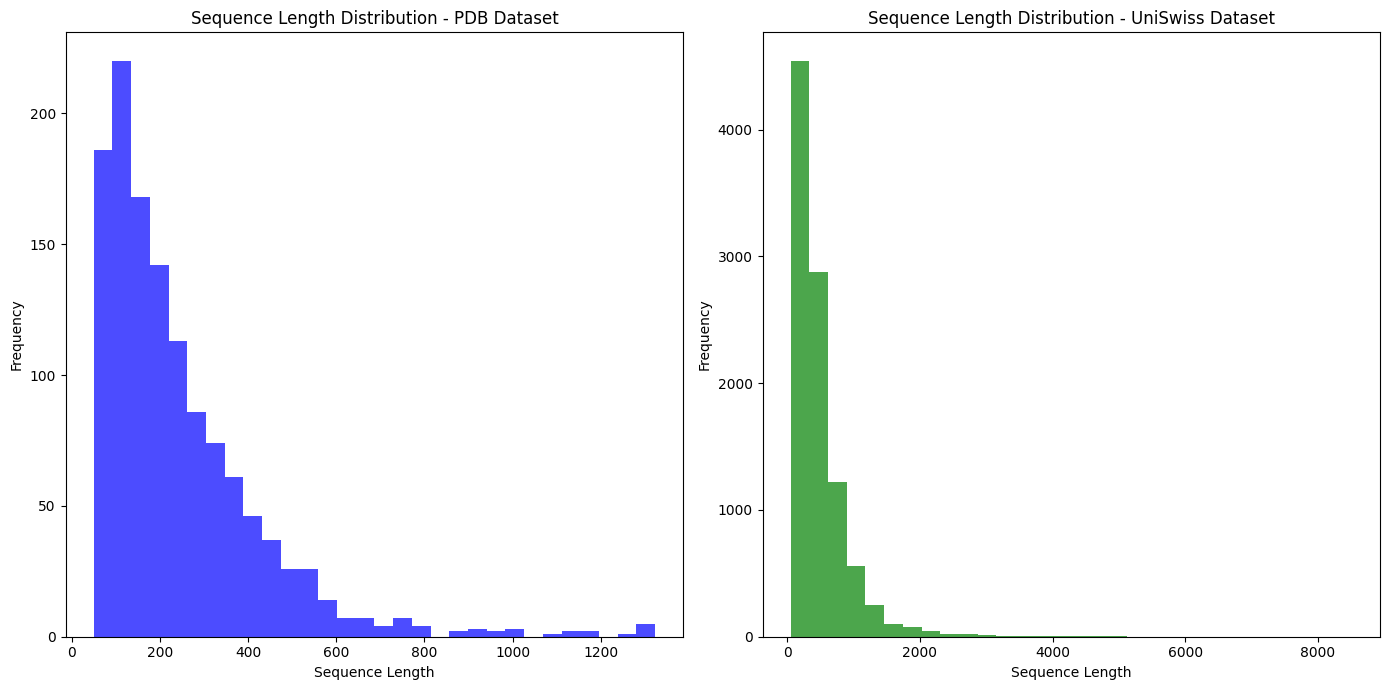

In [29]:
# Plot sequence length distribution for both datasets
plt.figure(figsize=(14, 7))

# PDB Sequence Length Distribution Visual
plt.subplot(1, 2, 1)
plt.hist(pdb['seq_len'], bins=30, alpha=0.7, color='blue')
plt.title('Sequence Length Distribution - PDB Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

# UniSwiss Sequence Length Distribution Visual
plt.subplot(1, 2, 2)
plt.hist(uniswiss['seq_len'], bins=30, alpha=0.7, color='green')
plt.title('Sequence Length Distribution - UniSwiss Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

###2. Class Distribution

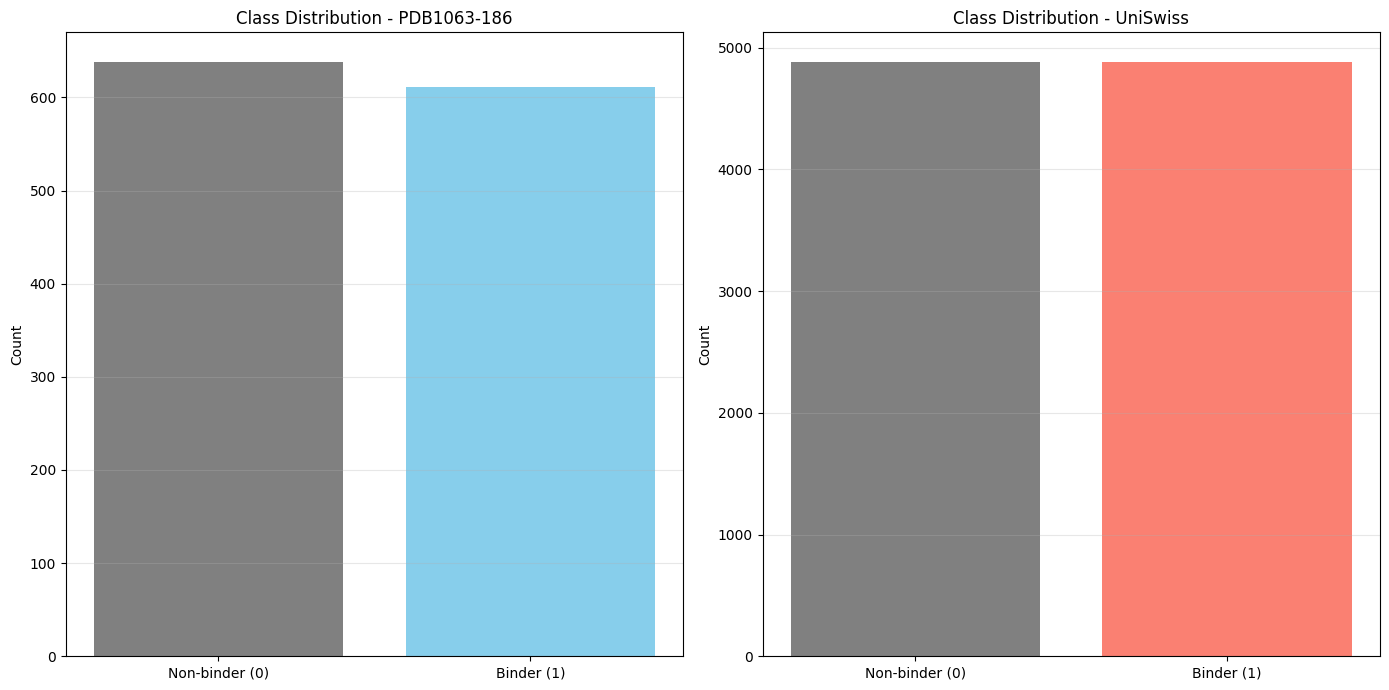

In [39]:
# Plot class for both datasets
plt.figure(figsize=(14, 7))

# Get PDB Class Distribution Visual
plt.subplot(1, 2, 1)
plt.bar(['Non-binder (0)', 'Binder (1)'], pdb_label_counts.sort_index(), color=['gray','skyblue'])
plt.title('Class Distribution - PDB1063-186')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# UniSwiss Class Distribution Visual
plt.subplot(1, 2, 2)
plt.bar(['Non-binder (0)', 'Binder (1)'], uniswiss_label_counts.sort_index(), color=['gray','salmon'])
plt.title('Class Distribution - UniSwiss')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

###3. Amino Acid Composition

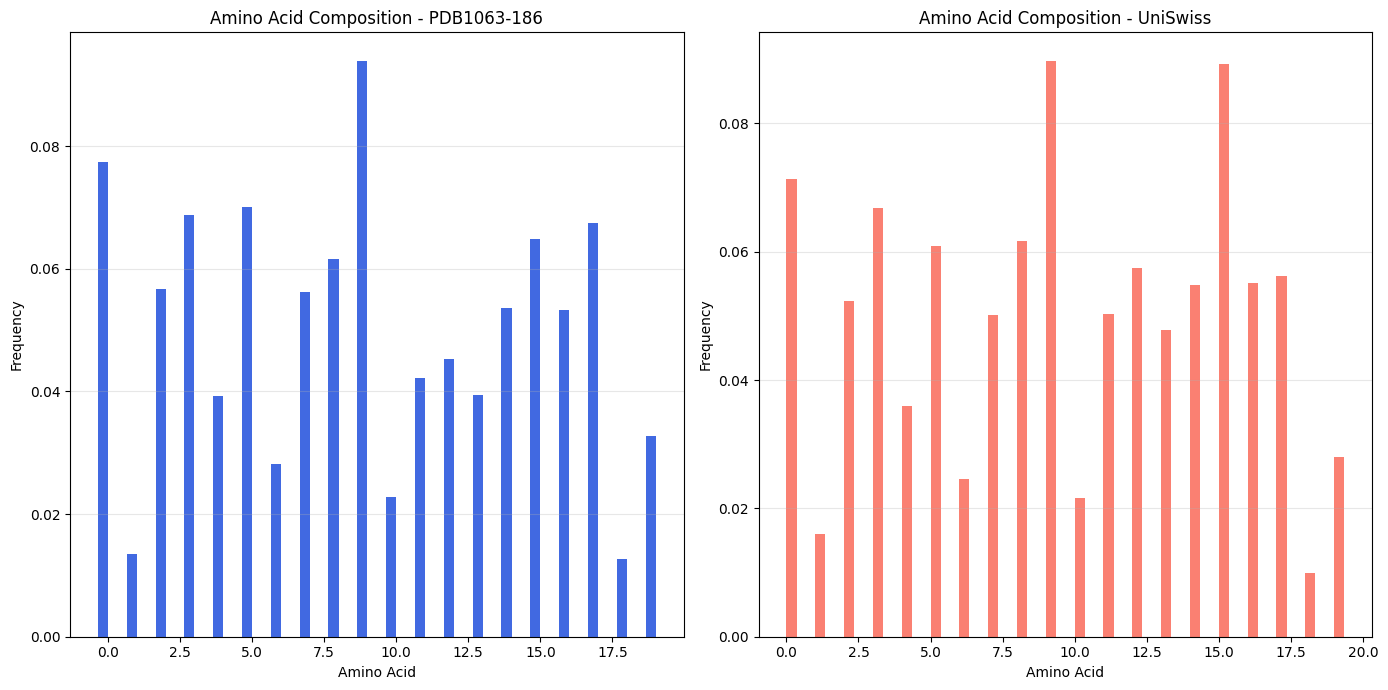

In [56]:
def amino_acid_composition(sequences):
    all_seq = ''.join(sequences)
    freq = Counter(all_seq)
    amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
    total = sum(freq.values())
    composition = [freq.get(aa,0)/total for aa in amino_acids]
    return amino_acids, composition

# Calculate composition for Both dataset
aas, comp_pdb = amino_acid_composition(pdb['sequence'])
__, comp_uni = amino_acid_composition(uniswiss['sequence'])

# Plot class for both datasets
plt.figure(figsize=(14,7))
width = 0.35
x = np.arange(len(aas))

# Get Visual
plt.subplot(1, 2, 1)
plt.bar(x - width/2, comp_pdb, width=width, color='royalblue', label='PDB1063-186')
plt.title('Amino Acid Composition - PDB1063-186')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(x + width/2, comp_uni, width=width, color='salmon', label='UniSwiss')
plt.title('Amino Acid Composition - UniSwiss')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



#**Pre-Processing & Baseline Models**
##Objective
1. Feature Extraction
2. SVM
3. MLP
4. LightGBM


###1. Feature Extraction

In [63]:
# feature extraction with AAC Composition-based
def AAC(seq):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    counts = np.array([seq.count(a) for a in aa], dtype=float)
    return counts / len(seq)

X = np.vstack(pdb['sequence'].apply(AAC))
y = pdb['label'].values

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (1249, 20)
Labels shape: (1249,)


###2. SVM

=== SVM Baseline Results ===
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        96
           1       0.79      0.75      0.77        92

    accuracy                           0.78       188
   macro avg       0.78      0.78      0.78       188
weighted avg       0.78      0.78      0.78       188

ROC-AUC: 0.8265964673913043


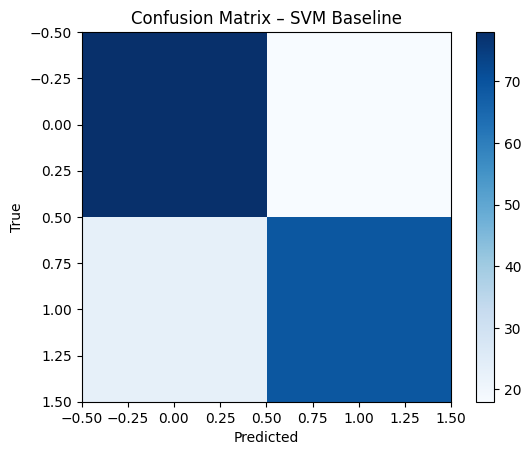

In [64]:
# Split dataset (85% train / 15% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions and probabilities
svm_preds = svm_model.predict(X_test_scaled)
svm_probs = svm_model.predict_proba(X_test_scaled)[:,1]

# Evaluation
print("=== SVM Baseline Results ===")
print(classification_report(y_test, svm_preds))
print("ROC-AUC:", roc_auc_score(y_test, svm_probs))

# Confusion matrix
cm = confusion_matrix(y_test, svm_preds)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix – SVM Baseline')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
plt.show()

###3. MLP

###4. LightBGM